# CNN + MaxPool
CNN with GenCode 43 data.
Merge cell lines.
Ten rounds of CV.

TO DO:
* Balance the sets?
* Remove the middle.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-03-04 22:17:27.687089
Python 3.8.10
sklearn 1.2.1


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO' # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [4]:
RCI_FILE       = 'train.lncRNA_RCI.csv'
SEQUENCE_FILE  = 'train.canon_lncRNA_transcripts.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        rci_avg = np.mean(np.array(rci_values)) # antilogs?
                        gene_to_rci[gene_id] = rci_avg
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-04 22:18:08.860721
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            gmm = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            gmm.fit(rci_values)
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = 0
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def do_cross_validation(self):
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True) # random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_rci = self._get_X_y(train_index)
            self._prepare_threshold(y_rci)  # use train subset only!
            self._explain_threshold()
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index)
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None

            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)
            self._show_sizes('Train',y_train)
            self._show_sizes('Valid',y_valid)
            self._show_sizes('Predict',yhat_classes)

            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            precision = precision_score(y_valid, yhat_classes)*100.
            recall = recall_score(y_valid, yhat_classes)*100.
            f1 = f1_score(y_valid, yhat_classes)*100.
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.
            mcc = matthews_corrcoef(y_valid, yhat_classes)

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)

                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()

            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
            self.cv_accuracy.append(accuracy)
            self.cv_precision.append(precision)
            self.cv_recall.append(recall)
            self.cv_f1.append(f1)
            self.cv_mcc.append(mcc)
            self.cv_auprc.append(auprc)
            self.cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()

        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


2023-03-04 22:18:12.678348
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.
Cross validation...
2023-03-04 22:18:24.389185
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 22:18:25.580073
PREDICT
2023-03-04 22:18:47.541892
Train 1:0 915:2473 27.01%
Valid 1:0 228:620 26.89%
Predict 1:0 33:815  3.89%


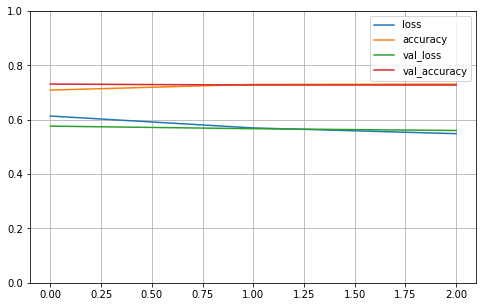

Compute valiation accuracy
Valid sizes (848, 4997) (848,)
Range of scores: 0.044388704 to 0.6659729
Score threshold 0.5


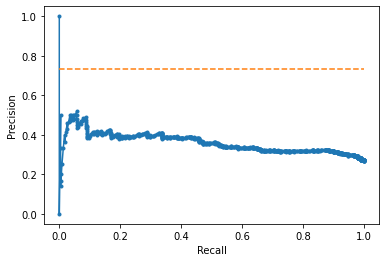

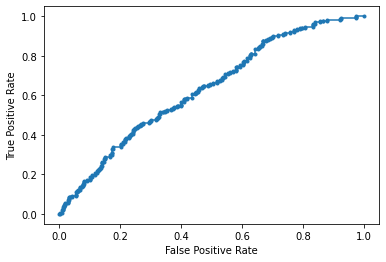

Accuracy: 72.76% Precision: 45.45% Recall: 6.58%
F1: 11.49% MCC: 0.08%
AUPRC: 36.04% AUROC: 63.23%
2023-03-04 22:18:48.537955
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 22:18:50.990778
PREDICT
2023-03-04 22:18:56.531320
Train 1:0 922:2467 27.21%
Valid 1:0 221:626 26.09%
Predict 1:0 6:841  0.71%


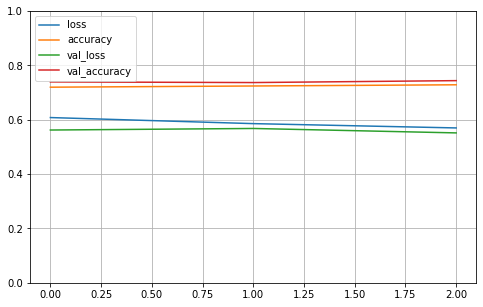

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.0002901982 to 0.58129025
Score threshold 0.5


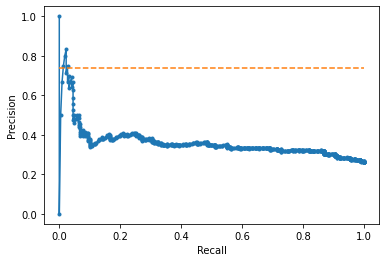

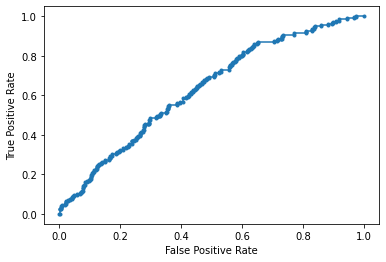

Accuracy: 74.38% Precision: 83.33% Recall: 2.26%
F1: 4.41% MCC: 0.11%
AUPRC: 36.00% AUROC: 63.26%
2023-03-04 22:18:57.474060
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 22:19:00.524655
PREDICT
2023-03-04 22:19:05.879996
Train 1:0 928:2461 27.38%
Valid 1:0 215:632 25.38%
Predict 1:0 0:847  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


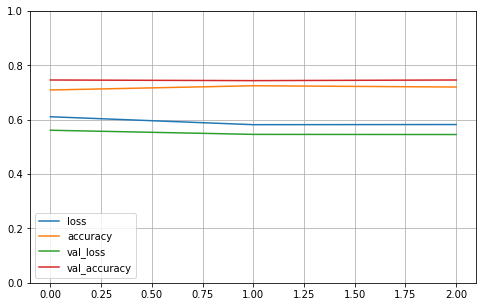

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.03021161 to 0.47279662
Score threshold 0.5


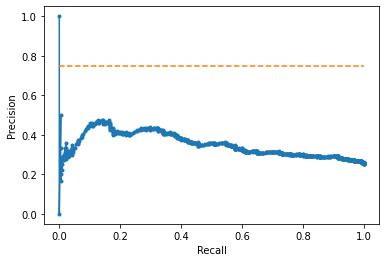

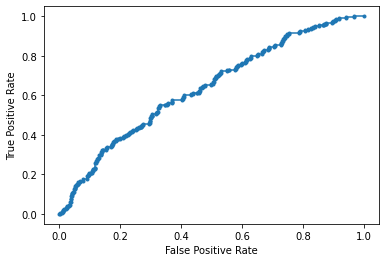

Accuracy: 74.62% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.00%
AUPRC: 35.15% AUROC: 63.74%
2023-03-04 22:19:06.766330
Fold 4
Discriminator ZERO 0
FIT
2023-03-04 22:19:09.233783
PREDICT
2023-03-04 22:19:15.644881
Train 1:0 911:2478 26.88%
Valid 1:0 232:615 27.39%
Predict 1:0 3:844  0.35%


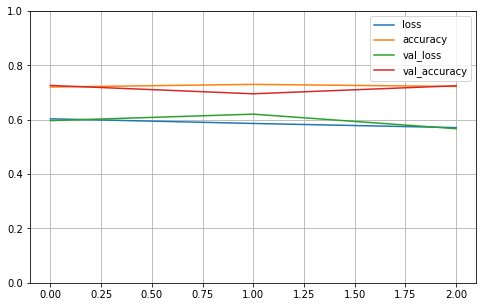

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.045135614 to 0.5560018
Score threshold 0.5


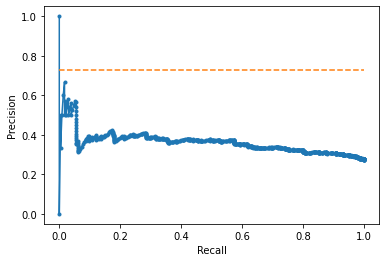

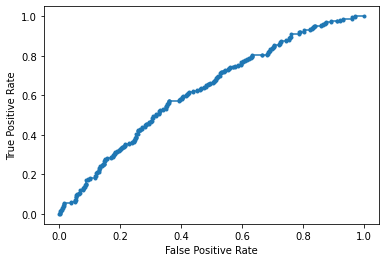

Accuracy: 72.49% Precision: 33.33% Recall: 0.43%
F1: 0.85% MCC: 0.01%
AUPRC: 36.20% AUROC: 62.47%
2023-03-04 22:19:16.524410
Fold 5
Discriminator ZERO 0
FIT
2023-03-04 22:19:19.004268
PREDICT
2023-03-04 22:19:25.308651
Train 1:0 896:2493 26.44%
Valid 1:0 247:600 29.16%
Predict 1:0 58:789  6.85%


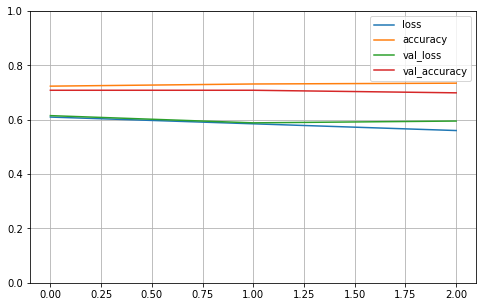

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.070357926 to 0.6363456
Score threshold 0.5


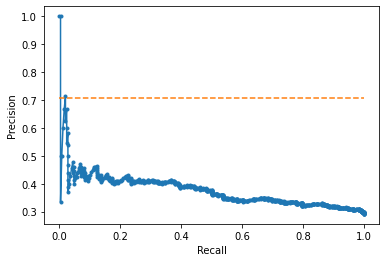

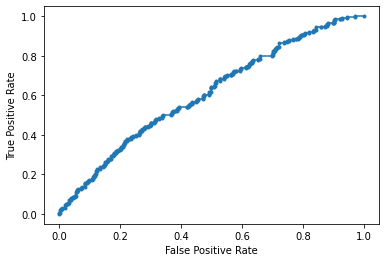

Accuracy: 69.89% Precision: 43.10% Recall: 10.12%
F1: 16.39% MCC: 0.08%
AUPRC: 37.80% AUROC: 60.83%
2023-03-04 22:19:27.743135

2023-03-04 22:19:29.035438
splitting
Fold 1
Discriminator ZERO 0
FIT
2023-03-04 22:19:30.211868
PREDICT
2023-03-04 22:19:36.480566
Train 1:0 907:2481 26.77%
Valid 1:0 236:612 27.83%
Predict 1:0 2:846  0.24%


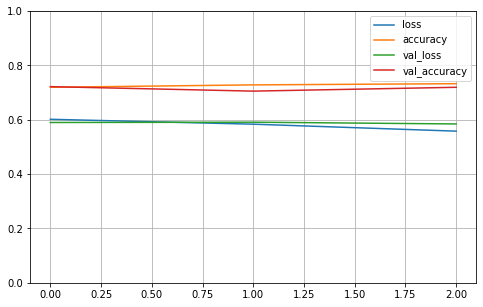

Compute valiation accuracy
Valid sizes (848, 4997) (848,)
Range of scores: 0.028492885 to 0.54718477
Score threshold 0.5


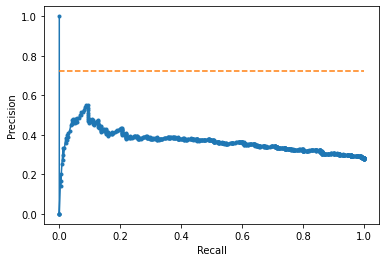

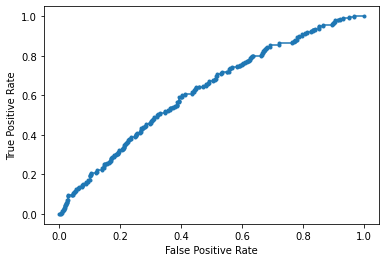

Accuracy: 71.93% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: -0.03%
AUPRC: 36.61% AUROC: 62.27%
2023-03-04 22:19:37.364640
Fold 2
Discriminator ZERO 0
FIT
2023-03-04 22:19:40.622136
PREDICT
2023-03-04 22:19:46.901484
Train 1:0 942:2447 27.80%
Valid 1:0 201:646 23.73%
Predict 1:0 0:847  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


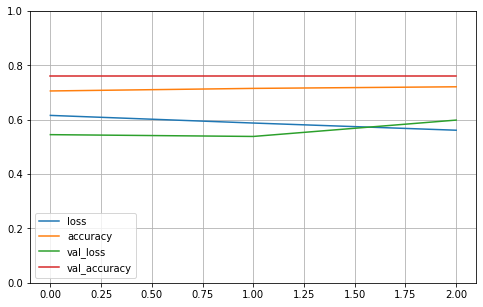

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.012198349 to 0.35332072
Score threshold 0.5


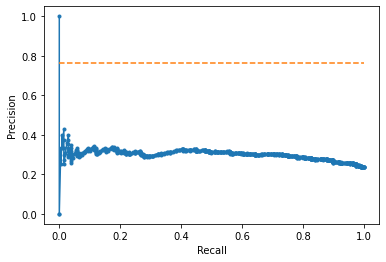

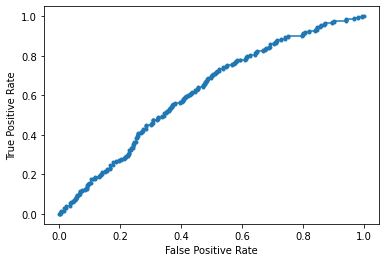

Accuracy: 76.27% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.00%
AUPRC: 30.07% AUROC: 61.82%
2023-03-04 22:19:47.769207
Fold 3
Discriminator ZERO 0
FIT
2023-03-04 22:19:50.295839
PREDICT
2023-03-04 22:19:56.628372
Train 1:0 892:2497 26.32%
Valid 1:0 251:596 29.63%
Predict 1:0 0:847  0.00%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


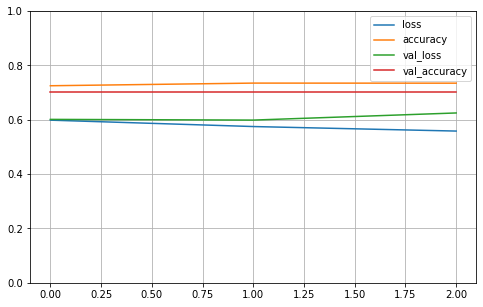

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.019813694 to 0.4099188
Score threshold 0.5


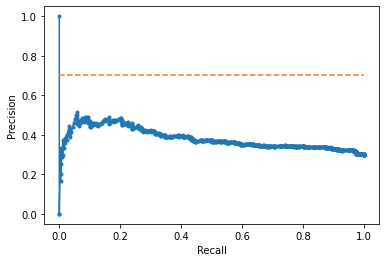

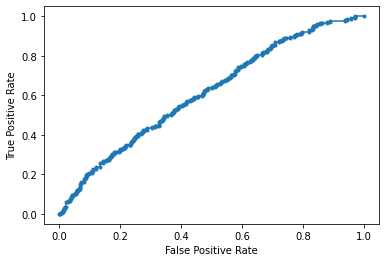

Accuracy: 70.37% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.00%
AUPRC: 38.11% AUROC: 61.43%
2023-03-04 22:19:57.527078
Fold 4
Discriminator ZERO 0
FIT
2023-03-04 22:19:59.979265
PREDICT
2023-03-04 22:20:05.915828
Train 1:0 914:2475 26.97%
Valid 1:0 229:618 27.04%
Predict 1:0 8:839  0.94%


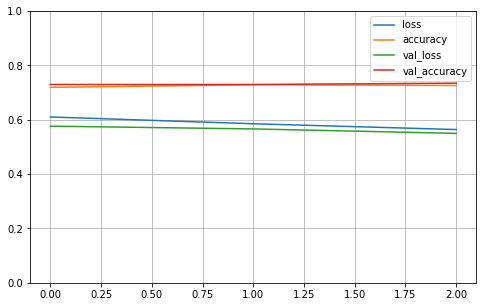

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.0010749338 to 0.55764514
Score threshold 0.5


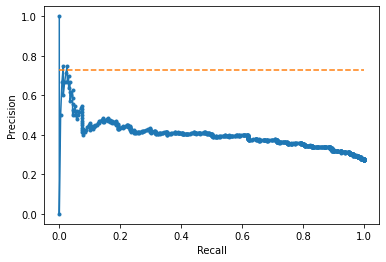

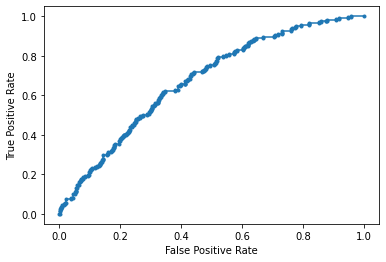

Accuracy: 73.44% Precision: 75.00% Recall: 2.62%
F1: 5.06% MCC: 0.11%
AUPRC: 40.18% AUROC: 67.39%
2023-03-04 22:20:07.034933
Fold 5
Discriminator ZERO 0
FIT
2023-03-04 22:20:09.509104
PREDICT
2023-03-04 22:20:15.862388
Train 1:0 917:2472 27.06%
Valid 1:0 226:621 26.68%
Predict 1:0 5:842  0.59%


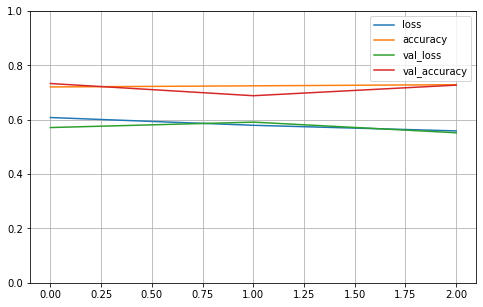

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.053389974 to 0.57489735
Score threshold 0.5


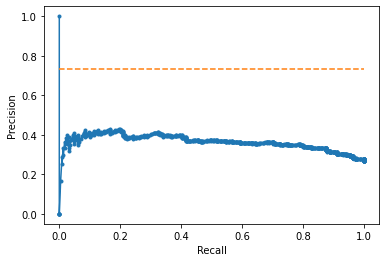

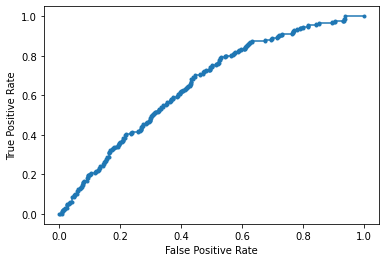

Accuracy: 72.73% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: -0.05%
AUPRC: 36.38% AUROC: 65.52%
2023-03-04 22:20:16.811741

Completed cross validation 5 folds 3 epochs
Repeated for a total of 10 folds
 accuracy mean 72.89% std 1.93
 precision mean 28.02% std 32.92
 recall mean 2.20% std 3.49
 F1 mean 3.82% std 5.78
 MCC mean 0.03% std 0.06
 AUPRC mean 36.26% std 2.60
 AUROC mean 63.20% std 1.98

2023-03-04 22:20:18.215505


In [10]:
print(datetime.now())
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
loader = None  # drop K-mer cache to save RAM

print("Cross validation...")
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cvdo.set_sequences(allids,allseq)
cvdo.set_rci_map(gene_to_rci)
cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
# two rounds of 5 for 10 total
total_folds = 0
for F in range(2):
  total_folds += FOLDS
  cvdo.do_cross_validation()   
cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
    cvdo.get_statistics()
cvdo = None

def STD (values):
    return np.std(values,ddof=1)

print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print("Repeated for a total of %d folds" % total_folds)
print(" accuracy mean %.2f%% std %.2f" %  (np.mean(cv_accuracy),  STD(cv_accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(cv_precision), STD(cv_precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(cv_recall),    STD(cv_recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(cv_f1),        STD(cv_f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(cv_mcc),       STD(cv_mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(cv_auprc),     STD(cv_auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(cv_auroc),     STD(cv_auroc)))
print()
print(datetime.now())